In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate, remove_bad_data, chi2_analysis
import pandas as pd
import numpy as np
# from tqdm import tqdm
print(pp.__version__)
import matplotlib.pyplot as plt
import ruptures as rpt
from tqdm import tqdm
# from julia.PowerModels import run_ac_opf
# from julia.PowerModels import run_ac_opf

2.0.1


In [2]:
def create_measurement_unit(df_measurement, net):
    list_value=[]
    list_std=[]
    for index, row in df_measurement.iterrows():
        if row['element_type'] =='bus':
            if row['meas_type'] =='v':
                mu= net.res_bus.iloc[row['element'],0]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='p':
                mu= net.res_bus.iloc[row['element'],2]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='q':
                mu= net.res_bus.iloc[row['element'],3]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
                
        elif row['element_type'] =='line':
            if row['side']=='from':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                    
                    
        elif row['element_type'] =='trafo':
            if row['side']=='from':
                if row['meas_type'] == 'i':
                    mu =net.res_trafo.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'p':
                    mu =net.res_trafo.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'q':
                    mu =net.res_trafo.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='i':
                    mu =net.res_trafo.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='p':
                    mu =net.res_trafo.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='q':
                    mu =net.res_trafo.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
#         print(mu)  
        value = np.random.normal(mu, sigma, 1)
        list_value.append(value[0])
        list_std.append(sigma)
    df_measurement['value']=list_value
    df_measurement['std_dev']=list_std

    for index, row in df_measurement.iterrows():
        if row['element_type']=='bus':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'])
        elif row['element_type']=='line':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'], side=row['side'])
        elif row['element_type']=='trafo':
            if row['meas_type'] in ['p','q']:
                pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                      std_dev=row['std_dev'], element=row['element'], side=row['side'])
    return df_measurement, net

In [3]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.01
lower_bus_accuracy=0.99
upper_line_accuracy=1.03
lower_line_accuracy=0.97
upper_trafo_accuracy=1.03
lower_trafo_accuracy=0.97

In [4]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.8,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0,0])
# scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar=np.array([np.random.normal(item, 0.05, 1)[0] if item !=0 else np.zeros(1)[0] for ind in range(len(scaling_for_solar)-1) for item in np.linspace(scaling_for_solar[ind], scaling_for_solar[ind+1],60)])
scaling_for_solar=np.array([value if value >0 else np.zeros(1)[0] for value in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)

In [5]:
scaling_for_solar[0][800:805]=0.1
scaling_for_solar[0][705:710]=0.1
scaling_for_solar[0][677:682]=0.1

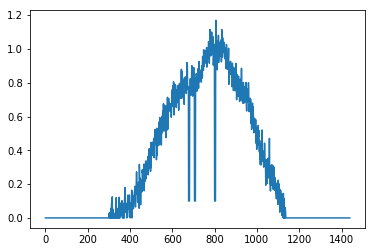

In [6]:
fig, ax = plt.subplots()

ax.plot(range(len(scaling_for_solar[0])), scaling_for_solar[0])
plt.show()

In [15]:
list_PV_loc=[]
list_PV_value=[]
list_PV_detected_loc=[]
list_PV_detected_value_1=[]
list_PV_detected_value_2=[]
list_PV_detected_value_3=[]


for round in tqdm(range(3), desc='round: '):
    p_mw=np.array([[0,0,0,0]])
    
    pv_location=np.zeros(2, dtype='int')
    while sum(pv_location) == 0:
        pv_location=np.random.randint(2, size=2) 
#     pv_location=np.array([1,1])
    print(pv_location)#     
    list_PV_loc.append(pv_location)
    net = pn.simple_four_bus_system()
    net.sgen.p_mw=np.random.randint(50, size=2)/1000
    list_PV_value.append(np.array(net.sgen.p_mw[:]))
    print(net.sgen.p_mw)
    net.sgen.q_mvar[:]=0
    for scaling_solar, load_scaling in zip(scaling_for_solar[0],scaling_for_load[0]):
        net.sgen.scaling=[scaling_solar*pv_location[0], scaling_solar*pv_location[1]]
        net.load.scaling=[load_scaling, load_scaling]
        pp.runpp(net)
        df_measurement=pd.DataFrame()
        df_measurement['meas_type']=['v','v','p','p','q','q','i','i']
        df_measurement['element_type']=['bus','bus','line','line','line','line','line','line']
        df_measurement['element']=[2,3,0,1,0,1,0,1]
        df_measurement['side']=['None','None','from','from','from','from','from','from']
        df_measurement, net = create_measurement_unit(df_measurement, net)
        success = estimate(net, init="slack", calculate_voltage_angles=True, zero_injection=[1])
        new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
        p_mw=np.concatenate((p_mw, new_mw), axis=0)

    df=pd.DataFrame()
    df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
    bus_has_solar_PV=[]
    list_corr=[]
    for bus in range(0,len(p_mw[0])):
        df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
        corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
        list_corr.append(corr)
#         print('correlation at bus {} is: {}'.format(bus, corr))
        if corr <-0.2:
            bus_has_solar_PV.append(bus)
    list_PV_detected_loc.append(bus_has_solar_PV)
    #combine solar scaling and p_mw at solar located bus
    new_p_mw=p_mw.copy()
    new_p_mw=new_p_mw.transpose()
    my_array=np.array([scaling_for_solar[0]]).T.copy()
    for located_bus in bus_has_solar_PV:
        my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

    algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
    my_bkps = algo.predict(pen=1)
    ## display
#     rpt.display(my_array, my_bkps)
#     plt.show()
    size_pv_1=[]
    size_pv_2=[]
    for bus in bus_has_solar_PV:
        sum_value=np.array([])
        for period in my_bkps[:-1]:
            value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
            if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
                sum_value = np.append(sum_value, value)

        mean = np.mean(sum_value, axis=0)
        sd = np.std(sum_value, axis=0)
        final_list = [x for x in sum_value if (x > mean - 2 * sd)]
        final_list = [x for x in final_list if (x < mean + 2 * sd)]
        size_pv_1.append(np.array(final_list).mean()*list_corr[bus])
        size_pv_2.append(np.array(final_list).mean())
        print('bus :', bus, 'has solar PV size: ', size_pv_1)
        print('bus :', bus, 'has solar PV size: ', size_pv_2)
        
    list_PV_detected_value_1.append(size_pv_1)
    list_PV_detected_value_2.append(size_pv_2)

 

round:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1]
0    0.004
1    0.006
Name: p_mw, dtype: float64


round:  33%|███▎      | 1/3 [03:45<07:30, 225.50s/it]

bus : 2 has solar PV size:  [-0.0022609207847724623]
bus : 2 has solar PV size:  [0.007678958591832143]
bus : 3 has solar PV size:  [-0.0022609207847724623, -0.003795946457208968]
bus : 3 has solar PV size:  [0.007678958591832143, 0.009056781276113542]
[1 0]
0    0.003
1    0.033
Name: p_mw, dtype: float64


round:  67%|██████▋   | 2/3 [07:39<03:48, 228.19s/it]

bus : 2 has solar PV size:  [-0.0028241118041066222]
bus : 2 has solar PV size:  [0.01220035095586556]
[1 1]
0    0.047
1    0.021
Name: p_mw, dtype: float64


round: 100%|██████████| 3/3 [11:33<00:00, 229.81s/it]

bus : 2 has solar PV size:  [0.03099095822563988]
bus : 2 has solar PV size:  [-0.03225962817269023]
bus : 3 has solar PV size:  [0.03099095822563988, 0.00542110445078304]
bus : 3 has solar PV size:  [-0.03225962817269023, -0.006431999445011484]


In [8]:
list_PV_loc

[array([0, 1]), array([1, 0]), array([1, 1])]

In [9]:
list_PV_value

[array([0.034, 0.007]), array([0.048, 0.018]), array([0.017, 0.049])]

In [10]:
list_PV_detected_loc

[[3], [2], [2, 3]]

In [11]:
list_PV_detected_value_3

[[-0.003594307912844514],
 [0.03133562649749799],
 [0.0022921944671171067, 0.031223880498110614]]

In [12]:
(list_PV_value-np.array(list_PV_detected_value_3))/list_PV_value*100

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

In [14]:
list_corr

[0.8692463739570855,
 0.041876476978472965,
 -0.01614060270015922,
 -0.9637712031513741]

In [16]:
#Analysis results


In [23]:
# samples
res_1=np.array([[0.044,0.024,0.020,0.011,0.043,0.014,0.027,0.047,0.010,0.012,0.031,0.034,0.030,0.006,0.004,0.041,
           0.026,0.006,0.047,0.027,0.047,0.018,0.038,0.031,0.045,0.007,0.037,0.039,0.008,0.048,0.040,0.036,
           0.024, 0.009,0.033,0.027,0.005,0.013,0.030,0.043,0.036,0.021,0.031,0.019,0.045,0.026,0.041,0.016,
           0.004,0.003,0.042,0.042,0.024,0.043,0.046],
          [0.047,0.036,0.034,0.021,0.048,0.026,0.035,0.054,0.019,0.022,0.039,0.044,0.039,0.013,0.009,0.047,
           0.038,0.012,0.051,0.037,0.051,0.018,0.044,0.043,0.046,0.014,0.046,0.045,0.015,0.053,0.045,0.045,
           0.033, 0.017,0.042,0.039,0.010,0.024,0.041,0.047,0.044,0.032,0.036,0.032,0.054,0.040,0.046,0.028,
           0.009,0.005,0.049,0.042,0.039,0.047,0.052]])
res_2=np.array([[0.002,0.001,0.001,0.002]])

In [28]:
abs(res_1[0]-res_1[1]).mean()

0.007690909090909092

In [30]:
abs(res_1[0]-res_1[1]).std()

0.003531019565727967

In [34]:
abs((res_1[0]-res_1[1])/res_1[0]).mean()*100

44.51942407550503

In [54]:
res_1_to_10_kw=np.array([[],[]])
res_10_to_20_kw=np.array([[],[]])
res_20_to_30_kw=np.array([[],[]])
res_30_to_40_kw=np.array([[],[]])
res_40_to_50_kw=np.array([[],[]])
for ind in range(len(res_1[0])):
    if (res_1[0][ind] <=0.01):
        res_1_to_10_kw=np.append(res_1_to_10_kw, np.array([[res_1[0][ind]], [res_1[1][ind]]]), axis=1)
    elif (res_1[0][ind] <=0.02):
        res_10_to_20_kw=np.append(res_10_to_20_kw, np.array([[res_1[0][ind]], [res_1[1][ind]]]), axis=1)
    elif (res_1[0][ind] <=0.03):
        res_20_to_30_kw=np.append(res_20_to_30_kw, np.array([[res_1[0][ind]], [res_1[1][ind]]]), axis=1)
    elif (res_1[0][ind] <=0.04):
        res_30_to_40_kw=np.append(res_30_to_40_kw, np.array([[res_1[0][ind]], [res_1[1][ind]]]), axis=1)
    elif (res_1[0][ind] <=0.05):
        res_40_to_50_kw=np.append(res_40_to_50_kw, np.array([[res_1[0][ind]], [res_1[1][ind]]]), axis=1)



In [58]:
abs((res_1_to_10_kw[0]-res_1_to_10_kw[1])/res_1_to_10_kw[0]).mean()*100

99.97222222222221

In [59]:
abs((res_10_to_20_kw[0]-res_10_to_20_kw[1])/res_10_to_20_kw[0]).mean()*100

69.74914340045919

In [60]:
abs((res_20_to_30_kw[0]-res_20_to_30_kw[1])/res_20_to_30_kw[0]).mean()*100

43.65079365079365

In [61]:
abs((res_30_to_40_kw[0]-res_30_to_40_kw[1])/res_30_to_40_kw[0]).mean()*100

22.959117171300424

In [62]:
abs((res_40_to_50_kw[0]-res_40_to_50_kw[1])/res_40_to_50_kw[0]).mean()*100

10.542929045589736

In [63]:
abs(res_1_to_10_kw[0]-res_1_to_10_kw[1]).mean()

0.0060999999999999995

In [65]:
abs(res_10_to_20_kw[0]-res_10_to_20_kw[1]).mean()

0.01025

In [66]:
abs(res_20_to_30_kw[0]-res_20_to_30_kw[1]).mean()

0.011181818181818182

In [68]:
abs(res_30_to_40_kw[0]-res_30_to_40_kw[1]).mean()

0.007909090909090909

In [69]:
abs(res_40_to_50_kw[0]-res_40_to_50_kw[1]).mean()

0.004666666666666667

In [2]:
import numpy as np

In [3]:

# samples
res_1=np.array([[7,36,6,30,3,22,47,16,9,11,11,25,46,14,44,13,5,33,41,16,48,36,3,     17,46,32,3,  20,11,
                 11,29,47,39,39,32,23,36,48,30,49,6,44,8,24,24,15,31,23,10,37,9,26,4,5,36,8,9,  7,10, 
                 33,42,9, 48,18,11,12,25,18,11,12,25,37,24,20,17,18,49,20,34,15,23,25,44,15,8,39,26,19,
                 21,15,6,7,10,49,5,17,11,27,12,38,28,30,39,43,14,4,29,28,29,30,39,30,7,48,42,30,36,28,
                 41,9,3,21,18,43,18,44,],
                [7,41,6,34,1.8,25,48,18,13,22,12,28,49,11,47,11,5,31,44,18,54,42,2.5,25,50,35,2.5,22,12,
                 13,33,51,42,51,39,26,41,53,35,55,6,50,8,27,28,13,35,27,10,42,9,34,3,5,40,8,6.9,8.6,10,
                 35,45,10,54,21,10,13,29,21,10,13,29,38,25,22,19,20,53,20,39,20,26,29,42,16,7,45,32,21,
                 24,18,7,6,10,54,5,18,12,33,13,43,32,34,34,47,15,1,33,21,30,32,42,32,6,50,45,37,37,30,
                 42,10,2,21,18,46,28,51]])
res_2=np.array([1,2,2,1,2,2,2,2,1])
res_3=np.array([])
res_4=np.zeros(60)

In [4]:
TP=len(res_1[1])
TN=len(res_4)
FP=len(res_3)
FN=len(res_2)
ACC=(TP+TN)/(TP+TN+FP+FN)
F_1=(2*TP)/(2*TP+FP+FN)
MCC=(TP*TN-FP*FN)/(np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))

In [5]:
print('ACC: ', ACC)
print('F1: ', F_1)
print('MCC: ', MCC)

ACC:  0.9538461538461539
F1:  0.9655172413793104
MCC:  0.9008852329229017


In [6]:

total_len=len(res_1[0])+len(res_2)+len(res_3)+len(res_4)
print('Total sample is:', total_len)
print('Actual=True & Prediction=True :', len(res_1[1]))
print('Actual=True & Prediction=False:', len(res_2))
print('Actual=False & Prediction=True :', len(res_3))
print('Actual=False & Prediction=False:', len(res_4))

Total sample is: 195
Actual=True & Prediction=True : 126
Actual=True & Prediction=False: 9
Actual=False & Prediction=True : 0
Actual=False & Prediction=False: 60


In [7]:
print('Actual=True & Prediction=True :', len(res_1[1])/total_len*100)

Actual=True & Prediction=True : 64.61538461538461


In [9]:
res_1_to_10_kw=np.array([[],[]])
res_10_to_20_kw=np.array([[],[]])
res_20_to_30_kw=np.array([[],[]])
res_30_to_40_kw=np.array([[],[]])
res_40_to_50_kw=np.array([[],[]])
for ind in range(len(res_1[0])):
    if (res_1[0][ind] <=10):
        res_1_to_10_kw=np.append(res_1_to_10_kw, np.array([[res_1[0][ind]], [res_1[1][ind]]]), axis=1)
    elif (res_1[0][ind] <=20):
        res_10_to_20_kw=np.append(res_10_to_20_kw, np.array([[res_1[0][ind]], [res_1[1][ind]]]), axis=1)
    elif (res_1[0][ind] <=30):
        res_20_to_30_kw=np.append(res_20_to_30_kw, np.array([[res_1[0][ind]], [res_1[1][ind]]]), axis=1)
    elif (res_1[0][ind] <=40):
        res_30_to_40_kw=np.append(res_30_to_40_kw, np.array([[res_1[0][ind]], [res_1[1][ind]]]), axis=1)
    elif (res_1[0][ind] <=50):
        res_40_to_50_kw=np.append(res_40_to_50_kw, np.array([[res_1[0][ind]], [res_1[1][ind]]]), axis=1)

In [10]:
abs((res_1_to_10_kw[0]-res_1_to_10_kw[1])/res_1_to_10_kw[0]).mean()*100

13.972663139329805

In [11]:
abs((res_10_to_20_kw[0]-res_10_to_20_kw[1])/res_10_to_20_kw[0]).mean()*100

16.972836744134053

In [12]:
abs((res_20_to_30_kw[0]-res_20_to_30_kw[1])/res_20_to_30_kw[0]).mean()*100

14.223753656448027

In [13]:
abs((res_30_to_40_kw[0]-res_30_to_40_kw[1])/res_30_to_40_kw[0]).mean()*100

12.265617838208998

In [14]:
abs((res_40_to_50_kw[0]-res_40_to_50_kw[1])/res_40_to_50_kw[0]).mean()*100

8.441963806247783

In [15]:
abs(res_1_to_10_kw[0]-res_1_to_10_kw[1]).mean()

0.774074074074074

In [16]:
abs(res_10_to_20_kw[0]-res_10_to_20_kw[1]).mean()

2.4838709677419355

In [17]:
abs(res_20_to_30_kw[0]-res_20_to_30_kw[1]).mean()

3.75

In [18]:
abs(res_30_to_40_kw[0]-res_30_to_40_kw[1]).mean()

4.421052631578948

In [19]:
abs(res_40_to_50_kw[0]-res_40_to_50_kw[1]).mean()

3.857142857142857

In [20]:
abs((res_1[0]-res_1[1])/res_1[0]).mean()*100

13.5874041672046

In [21]:
abs(res_1[0]-res_1[1]).mean()

2.9198412698412697

In [22]:
abs(res_1[0]-res_1[1]).std()

2.3682764425079417